In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Library Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

import random as r
from time import time

In [ ]:
def breaker():
    print("\n" + 30*"-"+ "\n")
    
def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()
    
def r2loss(y_true, y_pred):
  y_mean = torch.mean(y_true)
  ss_tol = 0
  for i in range(y_true.shape[0]):
    ss_tol += (y_true[i] - y_mean)**2
  ss_res = torch.sum((y_true - y_pred)**2)
  return (1 - (ss_res/ss_tol))[0]

def doSplit(X=None, y=None):
  return train_test_split(X, y, test_size=0.2, random_state=0)

si_60  = SimpleImputer(missing_values=np.nan, strategy="mean")
si_80  = SimpleImputer(missing_values=np.nan, strategy="mean")
si_110 = SimpleImputer(missing_values=np.nan, strategy="mean")

sc_X_60  = StandardScaler()
sc_X_80  = StandardScaler()
sc_X_110 = StandardScaler()
sc_y_60  = StandardScaler()
sc_y_80  = StandardScaler()
sc_y_110 = StandardScaler()

# Data Handling

In [ ]:
tr_60  = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/train_data_60.csv")
tr_80  = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/train_data_80.csv")
tr_110 = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/train_data_110.csv")
tr_out = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/train_outs.csv")

X_60  = tr_60.copy().values
X_80  = tr_80.copy().values
X_110 = tr_110.copy().values
y = tr_out["time_to_eruption"].copy().values

del tr_out
del tr_60
del tr_80
del tr_110

breaker()
print("TR_60     :", repr(X_60.shape))
breaker()
print("TR_80     :", repr(X_80.shape))
breaker()
print("TR_110    :", repr(X_110.shape))
breaker()
print("Out Shape :", repr(y.shape))
breaker()

num_features_60  = X_60.shape[1]
num_features_80  = X_80.shape[1]
num_features_110 = X_110.shape[1]
num_outputs      = 1


------------------------------

TR_60     : (4431, 60)

------------------------------

TR_80     : (4431, 80)

------------------------------

TR_110    : (4431, 110)

------------------------------

Out Shape : (4431,)

------------------------------



**Dataset Template**

In [ ]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y
    
  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

In [ ]:
X_train_60, X_valid_60, y_train_60, y_valid_60 = doSplit(X_60, y)
X_train_80, X_valid_80, y_train_80, y_valid_80 = doSplit(X_80, y)
X_train_110, X_valid_110, y_train_110, y_valid_110 = doSplit(X_110, y)

#################### Training Sets ###################
X_train_60 = si_60.fit_transform(X_train_60)
X_train_60 = sc_X_60.fit_transform(X_train_60)
y_train_60 = sc_y_60.fit_transform(y_train_60.reshape(-1,1)).reshape(-1)

X_train_80 = si_80.fit_transform(X_train_80)
X_train_80 = sc_X_80.fit_transform(X_train_80)
y_train_80 = sc_y_80.fit_transform(y_train_80.reshape(-1,1)).reshape(-1)

X_train_110 = si_110.fit_transform(X_train_110)
X_train_110 = sc_X_110.fit_transform(X_train_110)
y_train_110 = sc_y_110.fit_transform(y_train_110.reshape(-1,1)).reshape(-1)


#################### Validation Sets ##################
X_valid_60 = si_60.transform(X_valid_60)
X_valid_60 = sc_X_60.transform(X_valid_60)

X_valid_80 = si_80.transform(X_valid_80)
X_valid_80 = sc_X_80.transform(X_valid_80)

X_valid_110 = si_110.transform(X_valid_110)
X_valid_110 = sc_X_110.transform(X_valid_110)

##################### Datasets ########################
trds_60  = DS(X_train_60, y_train_60.reshape(-1,1))
trds_80  = DS(X_train_80, y_train_80.reshape(-1,1))
trds_110 = DS(X_train_110, y_train_110.reshape(-1,1))

vads_60  = DS(X_valid_60, y_valid_60.reshape(-1,1))
vads_80  = DS(X_valid_80, y_valid_80.reshape(-1,1))
vads_110 = DS(X_valid_110, y_valid_110.reshape(-1,1))

num_obs_valid = X_valid_60.shape[0]

# ANN Setup and Training

**Setup**

In [ ]:
class ANN_CFG():
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  batch_size = 256
  epochs = 50

  IL_60  = num_features_60
  IL_80  = num_features_80
  IL_110 = num_features_110

  HL = [2048, 2048, 2048]

  OL = num_outputs

cfg = ANN_CFG()

dataloaders = {"train_60"  : DL(trds_60, batch_size=cfg.batch_size, shuffle=True),
               "train_80"  : DL(trds_80, batch_size=cfg.batch_size, shuffle=True),
               "train_110" : DL(trds_110, batch_size=cfg.batch_size, shuffle=True),

               "evals_60"  : DL(vads_60, batch_size=cfg.batch_size, shuffle=False),
               "evals_80"  : DL(vads_80, batch_size=cfg.batch_size, shuffle=False),
               "evals_110" : DL(vads_110, batch_size=cfg.batch_size, shuffle=False)
               }

In [ ]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None):
    super(ANN, this).__init__()

    this.BN1 = nn.BatchNorm1d(IL)
    this.DP1 = nn.Dropout(p=0.25)
    this.FC1 = WN(nn.Linear(IL, HL[0]))
        
    this.BN2 = nn.BatchNorm1d(HL[0])
    this.DP2 = nn.Dropout(p=0.5)
    this.FC2 = WN(nn.Linear(HL[0], HL[1]))
        
    this.BN3 = nn.BatchNorm1d(HL[1])
    this.DP3 = nn.Dropout(p=0.5)
    this.FC3 = WN(nn.Linear(HL[1], HL[2]))
        
    this.BN4 = nn.BatchNorm1d(HL[2])
    this.DP4 = nn.Dropout(p=0.5)
    this.FC4 = WN(nn.Linear(HL[2], OL))

  def forward(this, x):
    x = this.BN1(x)
    x = this.DP1(x)
    x = F.relu(this.FC1(x))
        
    x = this.BN2(x)
    x = this.DP2(x)
    x = F.relu(this.FC2(x))
        
    x = this.BN3(x)
    x = this.DP3(x)
    x = F.relu(this.FC3(x))
        
    x = this.BN4(x)
    x = this.DP4(x)
    x = this.FC4(x)
    return x

  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-3, weight_decay=0)

**Helper Functions used for ANN**

In [ ]:
def train_fn(model=None, optimizer=None, dataloader=None):
  LP = []
  model.train()

  start_time = time()

  for e in range(cfg.epochs):
    lossPerPass = 0
    for X, y in dataloader:
      X, y = X.to(cfg.device), y.to(cfg.device)

      optimizer.zero_grad()
      output = model(X)
      loss = nn.MSELoss()(output, y) + nn.L1Loss()(output, y)
      lossPerPass += loss.item()
      loss.backward()
      optimizer.step()
    LP.append(lossPerPass)
  
  breaker()
  print("Time Taken to Train : %.2f seconds" % (time() - start_time))
  breaker()
  return LP

def eval_fn(model=None, dataloader=None, mode="eval"):
  Pred = torch.zeros(cfg.batch_size, 1).to(cfg.device)

  model.eval()

  if mode == "eval":
    for X, y in dataloader:
      X = X.to(cfg.device)
      with torch.no_grad():
        output = model(X)
      Pred = torch.cat((Pred, output), dim=0)
  else:
    for X in dataloader:
      X = X.to(cfg.device)
      with torch.no_grad():
        output = model(X)
      Pred = torch.cat((Pred, output), dim=0)

  Pred = Pred[cfg.batch_size:]
  return Pred.cpu().numpy().reshape(-1)

**Training**

In [ ]:
Net_60 = ANN(cfg.IL_60, cfg.HL, cfg.OL)
Net_60.to(cfg.device)
optimizer_60 = Net_60.getOptimizer()

Net_80 = ANN(cfg.IL_80, cfg.HL, cfg.OL)
Net_80.to(cfg.device)
optimizer_80 = Net_80.getOptimizer()

Net_110 = ANN(cfg.IL_110, cfg.HL, cfg.OL)
Net_110.to(cfg.device)
optimizer_110 = Net_110.getOptimizer()

LP_60  = train_fn(Net_60, optimizer_60, dataloaders["train_60"])
LP_80  = train_fn(Net_80, optimizer_80, dataloaders["train_80"])
LP_110 = train_fn(Net_110, optimizer_110, dataloaders["train_110"])


------------------------------

Time Taken to Train : 6.91 seconds

------------------------------


------------------------------

Time Taken to Train : 6.92 seconds

------------------------------


------------------------------

Time Taken to Train : 6.92 seconds

------------------------------




------------------------------

Last Epoch Loss (60)  : 19.76

Last Epoch Loss (80)  : 18.31

Last Epoch Loss (110) : 18.64

------------------------------



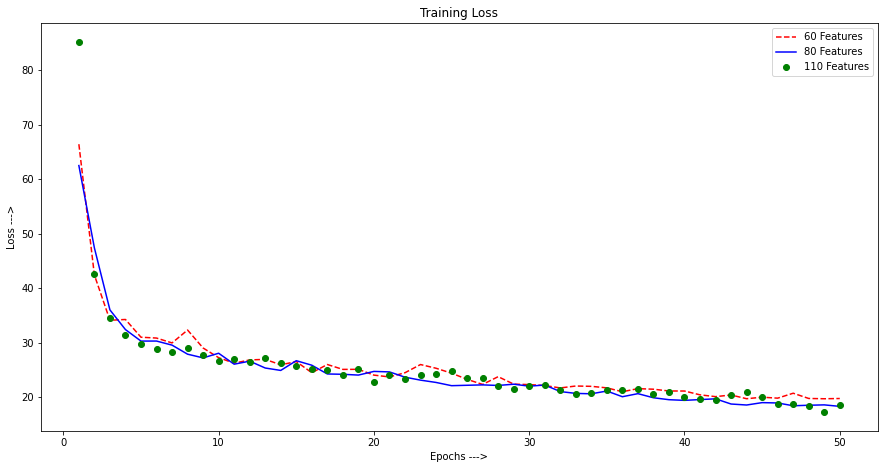

In [ ]:
breaker()
print("Last Epoch Loss (60)  : %.2f" % (LP_60[-1]))
print("\nLast Epoch Loss (80)  : %.2f" % (LP_80[-1]))
print("\nLast Epoch Loss (110) : %.2f" % (LP_110[-1]))
breaker()

x_Axis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(15, 7.5))
plt.plot(x_Axis, LP_60, "r--", label="60 Features")
plt.plot(x_Axis, LP_80, "b", label="80 Features")
plt.plot(x_Axis, LP_110, "go", label="110 Features")
plt.xlabel("Epochs --->")
plt.ylabel("Loss --->")
plt.title("Training Loss")
plt.legend()
plt.show()

In [ ]:
y_pred_60 = eval_fn(Net_60, dataloaders["evals_60"])
y_pred_60 = sc_y_60.inverse_transform(y_pred_60)

y_pred_80 = eval_fn(Net_80, dataloaders["evals_80"])
y_pred_80 = sc_y_80.inverse_transform(y_pred_80)

y_pred_110 = eval_fn(Net_110, dataloaders["evals_110"])
y_pred_110 = sc_y_110.inverse_transform(y_pred_110)

breaker()
print("MAE 60  : %.5f" % (mean_absolute_error(y_valid_60, y_pred_60)))
breaker()
print("MAE 80  : %.5f" % (mean_absolute_error(y_valid_80, y_pred_80)))
breaker()
print("MAE 110 : %.5f" % (mean_absolute_error(y_valid_110, y_pred_110)))
breaker()

del y_pred_60, y_pred_80, y_pred_110


------------------------------

MAE 60  : 8740655.93672

------------------------------

MAE 80  : 8207963.95660

------------------------------

MAE 110 : 7752534.45427

------------------------------



In [ ]:
ss = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/sample_submission.csv")

ss_60  = ss.copy()
ss_80  = ss.copy()
ss_110 = ss.copy()
ts_60  = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/test_data_60.csv")
ts_80  = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/test_data_80.csv")
ts_110 = pd.read_csv("/content/gdrive/My Drive/Datasets/Volcano/test_data_110.csv")

X_test_60  = ts_60.copy().values
X_test_80  = ts_80.copy().values
X_test_110 = ts_110.copy().values

del ts_60
del ts_80
del ts_110
del ss

X_test_60 = si_60.transform(X_test_60)
X_test_60 = sc_X_60.transform(X_test_60)

X_test_80 = si_80.transform(X_test_80)
X_test_80 = sc_X_80.transform(X_test_80)

X_test_110 = si_110.transform(X_test_110)
X_test_110 = sc_X_110.transform(X_test_110)

tsds_60  = DS(X_test_60, None, mode="test")
tsds_80  = DS(X_test_80, None, mode="test")
tsds_110 = DS(X_test_110, None, mode="test")

tsloaders = {"test_60"  : DL(tsds_60, batch_size=cfg.batch_size, shuffle=False),
             "test_80"  : DL(tsds_80, batch_size=cfg.batch_size, shuffle=False),
             "test_110" : DL(tsds_110, batch_size=cfg.batch_size, shuffle=False)
            }

y_pred_60 = eval_fn(Net_60, tsloaders["test_60"], mode="test")
y_pred_60 = sc_y_60.inverse_transform(y_pred_60)

y_pred_80 = eval_fn(Net_80, tsloaders["test_80"], mode="test")
y_pred_80 = sc_y_80.inverse_transform(y_pred_80)

y_pred_110 = eval_fn(Net_110, tsloaders["test_110"], mode="test")
y_pred_110 = sc_y_110.inverse_transform(y_pred_110)

ss_60["time_to_eruption"] = y_pred_60
ss_60.to_csv("/content/gdrive/My Drive/Datasets/Volcano/submission_60.csv",index=False)

ss_80["time_to_eruption"] = y_pred_80
ss_80.to_csv("/content/gdrive/My Drive/Datasets/Volcano/submission_80.csv",index=False)

ss_110["time_to_eruption"] = y_pred_110
ss_110.to_csv("/content/gdrive/My Drive/Datasets/Volcano/submission_110.csv",index=False)